# Amazon Reviews Sentiment Analysis


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [4]:
import os

def load_reviews(folder_path):
    reviews = [] # empty list for the reviews
    ratings = os.path.basename(folder_path) # the folder name is the ratings i.e. ..reviews/1 is 1 star etc
    
    for filename in os.listdir(folder_path): # iterate thru all files in the folder
        filepath = os.path.join(folder_path, filename) 

        if os.path.isfile(filepath):
            with open(filepath, 'r', encoding='utf-8') as file:
                reviews.append({'review': file.read(), 'rating': rating})
                
    return pd.DataFrame(reviews)
    

In [7]:
all_dfs = [] # empty list

# cycle thru each folder -- ie 'Data/reviews/1 , Data/reviews/2 , etc.'
for rating in range(1, 6):
    df_temp = load_reviews(os.path.join('Data/reviews', str(rating)))
    all_dfs.append(df_temp)


In [9]:
df = pd.concat(all_dfs, ignore_index=True)

In [12]:
df

,review,rating
0,I'll start by saying I barely write reviews. O...,1
1,SAMSUNG EVO Select Micro SD-Memory-Card + Adap...,1
2,Just received the cartridges and the yellow ra...,1
3,I've been using HP printers for a long time as...,1
4,These ink Cartridges work as they should becau...,1
...,...,...
20995,Anyone on the fence who needs better lighting ...,5
20996,Great product easy to assemble and the light d...,5
20997,"Fabulous, inexpensive light that works great f...",5
20998,didn't even need the directions for setting up...,5


In [51]:
df.duplicated().sum()

14509

In [50]:
duplicated_rows = df[df.duplicated(keep=False)]
print(duplicated_rows.sort_values(by="review").head(20))


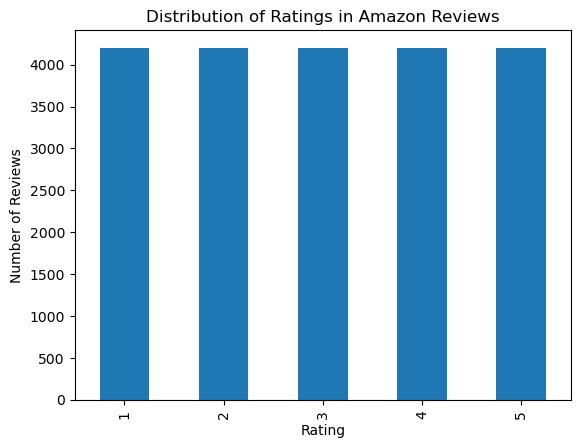

In [18]:
# number of reviews per rating score
df['rating'].value_counts().plot(kind='bar')
plt.title('Distribution of Ratings in Amazon Reviews')
plt.xlabel('Rating')
plt.ylabel('Number of Reviews')
plt.show()

In [20]:
#display full content of reviews
pd.set_option('display.max_colwidth', None)

# getting 2 samples from each rating score
for rating in range(1, 6):
    sample = df[df['rating'] == rating].sample(2)
    print(sample)
    print('-'*80)  


                                                                                                                        review  \
439   I have brought this brand for years. This is the first time the ink is printing as if the ink pack is empty. Very lite .   
1509                                         You get what you pay for. These crumpled badly in my machine. Will not buy again.   

      rating  
439        1  
1509       1  
--------------------------------------------------------------------------------
                                                                                                   review  \
4664  No me agrado esto para nada no se lo recomiendo a nadie esto bueno si podrían mejorar este producto   
5952        I bought the adapter so I can use it with my iphone and portable screen, and it doesn't work.   

      rating  
4664       2  
5952       2  
--------------------------------------------------------------------------------
                             

From this example I see there are some different languages in here. Let's try to filter to only English

In [21]:
!pip install langdetect

     ------------------------------------- 981.5/981.5 kB 10.3 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993253 sha256=01aa22ee31ad4183bceaa033e74b30f8e21c6da5ddb92f65235781c7c2ae92f9
  Stored in directory: c:\users\oconn\appdata\local\pip\cache\wheels\c4\16\af\1889804d8b7c0c041cadee8e29673a938a332acbf2865c70a1
Successfully built langdetect


In [22]:
from langdetect import detect, DetectorFactory

# Use random seed for reproducability
DetectorFactory.seed = 0

def is_english(text):
    try:
        # Return True if EN else flase
        return detect(text) == 'en' # True
    except:
        return False



In [23]:
# Filter df English reviews only
df_english_only = df[df['review'].apply(is_english)]

In [26]:
# number of non-english samples
df.shape[0] - df_english_only.shape[0]

339

### Binary Classification

I am going to start with simply classifying positive and negative sentiment. To do this I will consider 4 and 5 star reviews positive, 1 and 2 star reviews negative, and leave 3 star (neutral) reviews out for now. 

In [28]:
# filter out neutral reviews
df_binary = df_english_only[df_english_only['rating'] != 3].copy()

# apply pos is 4 or 5, neg is 1 or 2
df_binary['sentiment'] = df_binary['rating'].apply(lambda x: 'positive' if x > 3 else 'negative')



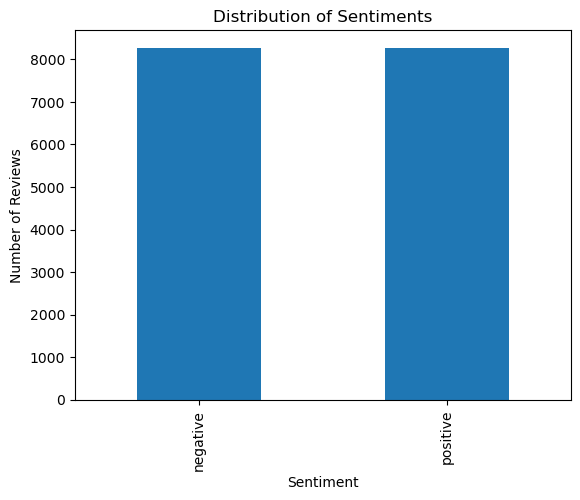

In [30]:
df_binary['sentiment'].value_counts().plot(kind='bar')
plt.title('Distribution of Sentiments')
plt.xlabel('Sentiment')
plt.ylabel('Number of Reviews')
plt.show()

Lets take a look at some of the most common words associated with both positive and negative reviews.

In [33]:
#seperating out pos and neg reviews
positive_reviews = df_binary[df_binary['sentiment'] == 'positive']['review']
negative_reviews = df_binary[df_binary['sentiment'] == 'negative']['review']

In [38]:
from sklearn.feature_extraction.text import CountVectorizer

#instantiate count vectorizer with english stop words
countvec_pos = CountVectorizer(stop_words='english')
countvec_neg = CountVectorizer(stop_words='english')

#vectorize both pos and neg reviews
pos = countvec_pos.fit_transform(positive_reviews)
neg = countvec_neg.fit_transform(negative_reviews)

In [36]:
pos.shape, neg.shape

((8271, 13648), (8271, 10205))

In [40]:
# create 2 df for each positive and negative words
pos_word_counts = pd.DataFrame(
    {"counts": pos.toarray().sum(axis=0)},
    index=countvec_pos.get_feature_names_out()
).sort_values("counts", ascending=False)

neg_word_counts = pd.DataFrame(
    {"counts": neg.toarray().sum(axis=0)},
    index=countvec_neg.get_feature_names_out()
).sort_values("counts", ascending=False)

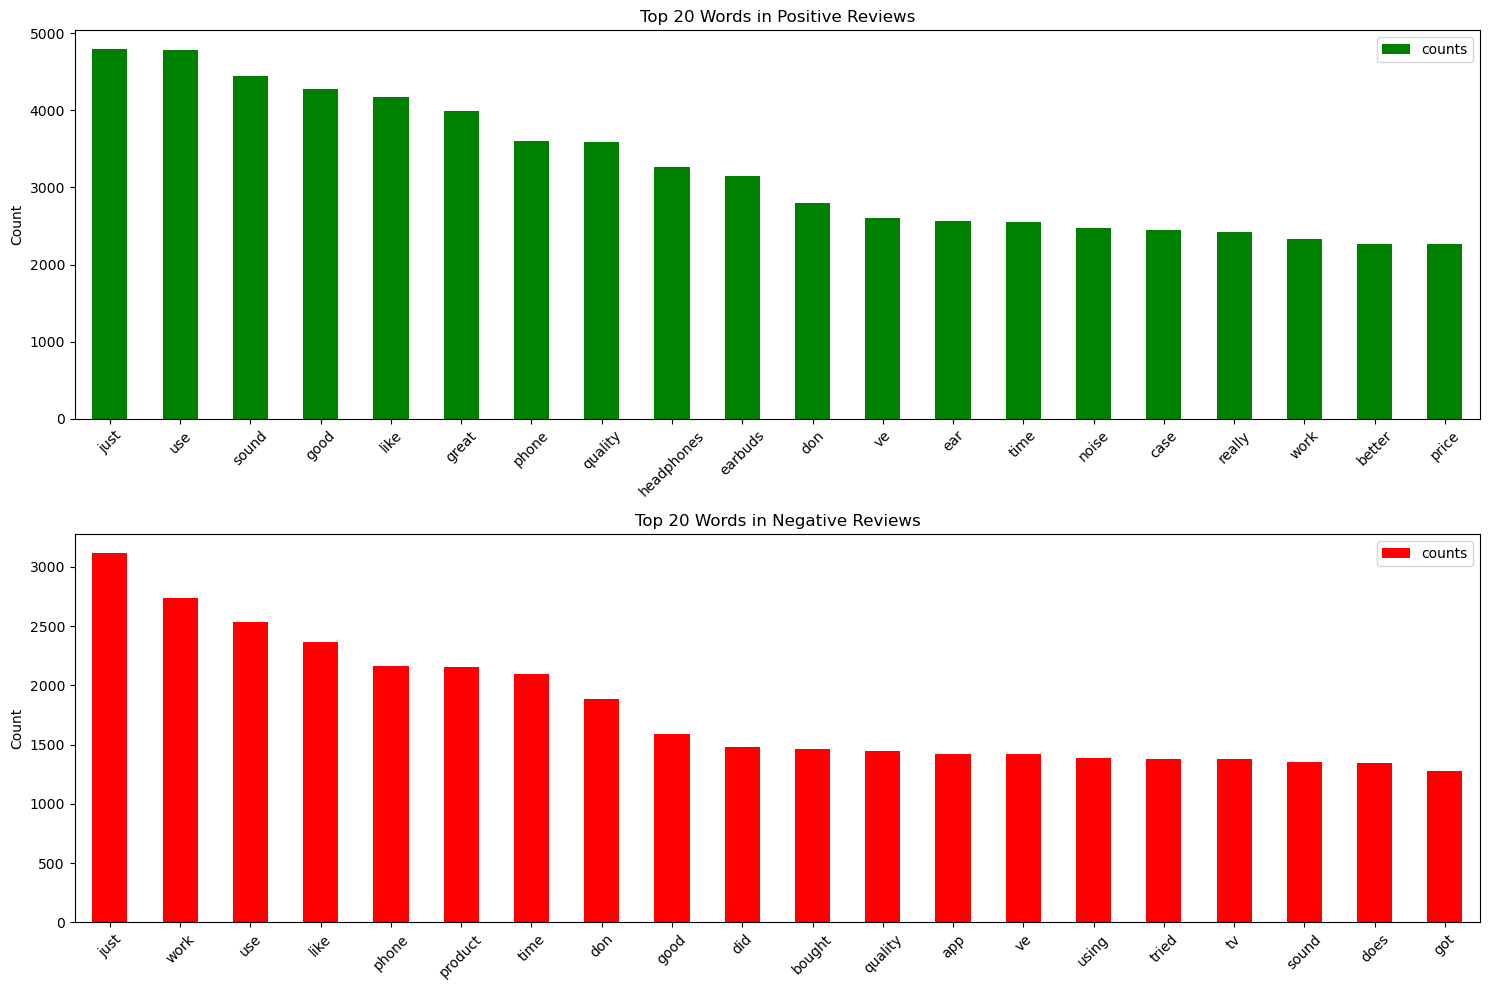

In [46]:


# Plotting for Positive Reviews
plt.figure(figsize=(15, 10))
plt.subplot(2, 1, 1)
pos_word_counts.head(20).plot(kind='bar', ax=plt.gca(), color='green')
plt.title('Top 20 Words in Positive Reviews')
plt.ylabel('Count')
plt.xticks(rotation=45)

# Plotting for Negative Reviews
plt.subplot(2, 1, 2)
neg_word_counts.head(20).plot(kind='bar', ax=plt.gca(), color='red')
plt.title('Top 20 Words in Negative Reviews')
plt.ylabel('Count')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()
